Na přednášce jsme se bavili o konvolučních sítích, dnes se je vyzkoušíme. Kromě toho si ukážeme tensorboard a knihovnu pro vytváření matoucích vzorů.

## Konvoluční sítě v tensorflow

Implementovat konvoluční síť v tensorflow je skoro stejné jako implementace jiných architektur. Než se dostaneme k trénování modelů, podíváme se na dva často používané datasety. MNIST obsahuje černobílé obrázky číslic 1-10, CIFAR10 obsahuje barevné obrázky z 10 různých tříd.

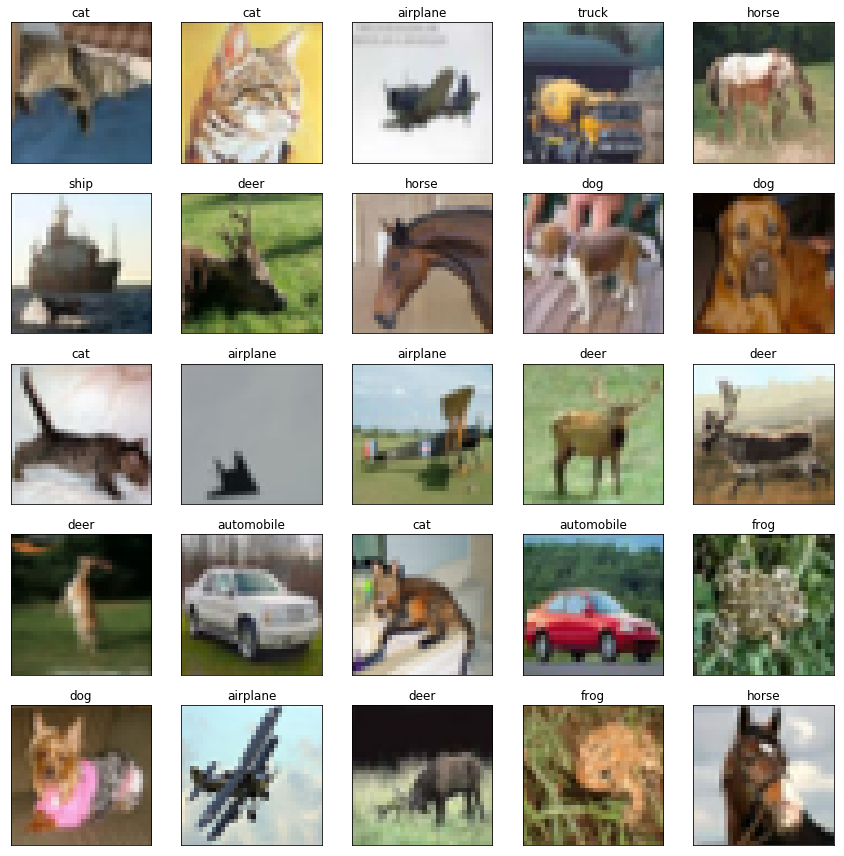

In [1]:
import random

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

def show_dataset_examples(X, y, labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        idx = random.randint(0, X.shape[0]) 
        plt.subplot(5, 5, i+1)
        plt.imshow(X[idx])
        plt.title(labels[y[idx]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

cifar_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

show_dataset_examples(x_train/255, list(map(lambda x: x[0], y_train)), cifar_class_labels)

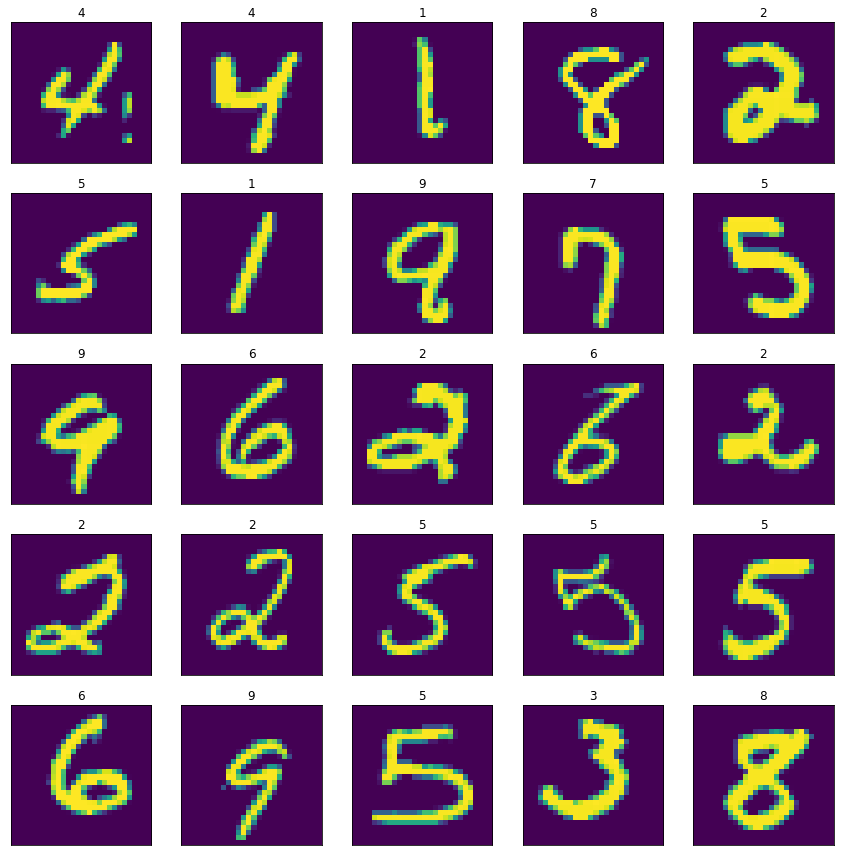

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

mnist_class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_dataset_examples(x_train, y_train, mnist_class_labels)

Vytvoříme si teď jednoduchý model a natrénujeme ho pro klasifikaci číslic z MNISTu.

In [3]:
nb_classes = 10
input_shape = (28, 28, 1)

x_train = x_train.reshape((-1,) + input_shape)/255

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = input_shape),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2, 2)),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dense(units=30, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=nb_classes, activation=tf.keras.activations.linear, name='logits'),
    tf.keras.layers.Activation(activation=tf.nn.softmax)
    ]
)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=128, epochs=10)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/10
60000/60000 [==============================] - 39s 653us/sample - loss: 0.2314 - acc: 0.93042s
Epoch 2/10
60000/60000 [==============================] - 43s 723us/sample - loss: 0.0673 - acc: 0.9796
Epoch 3/10
60000/60000 [==============================] - 41s 691us/sample - loss: 0.0481 - acc: 0.9849
Epoch 4/10
60000/60000 [==============================] - 44s 726us/sample - loss: 0.0368 - acc: 0.9885
Epoch 5/10
60000/60000 [==============================] - 43s 722us/sample - loss: 0.0292 - acc: 0.9908
Epoch 6/10
60000/60000 [==============================] - 40s 674us/sample - loss: 0.0237 - acc: 0.9927
Epoch 7/10
60000/60000 [==============================] - 41s 685us/sample - loss: 0.0215 - acc: 0.9928
Epoch 8/10
60000/60000 [==============================] - 41s 691us/sample - loss: 0.0178 - acc: 0.9940
Epoch 9/10
60000/60000 [==============================] - 40s 672us/sample - loss: 0.0147 - ac

In [7]:
# spocitame accuracy na testovacich datech
x_test = x_test.reshape((-1,) + input_shape)

model.evaluate(x_test/255, y_test)

10000/10000 [==============================] - 3s 254us/sample - loss: 0.0424 - acc: 0.9890


[0.04237177605305842, 0.989]

## Matoucí vzory

Na přednášce jsme se bavili i o tom, že konvoluční sítě lze docela snadno zmást pomocí tzv. matoucích vzorů. Matoucí vzory můžeme vygenerovat pomocí knihovny `cleverhans`. Tato knihovna potřebuje tensor aktivací před poslední (softmax) vrstvou. Tu jsme si ale pojmenovali `logits`, není tedy problém si z našeho modelu vzít jen tu část, kterou potřebujeme.

In [8]:
import cleverhans.attacks

logits = tf.keras.Model(model.inputs, model.get_layer('logits').output)

attack = cleverhans.attacks.FastGradientMethod(cleverhans.model.CallableModelWrapper(logits, 'logits'), 
                                               sess=tf.keras.backend.get_session())

results = []
eps_vals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
for eps in eps_vals:
    adv_x = attack.generate_np(x_test/255, eps=eps)
    r = model.evaluate(adv_x, y_test)[1]
    results.append(r)

print(results)

[INFO 2019-04-14 21:47:41,271 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 3s 311us/sample - loss: 13.2448 - acc: 0.0647
[0.989, 0.8453, 0.4706, 0.2818, 0.1837, 0.1287, 0.0958, 0.0767, 0.0647]


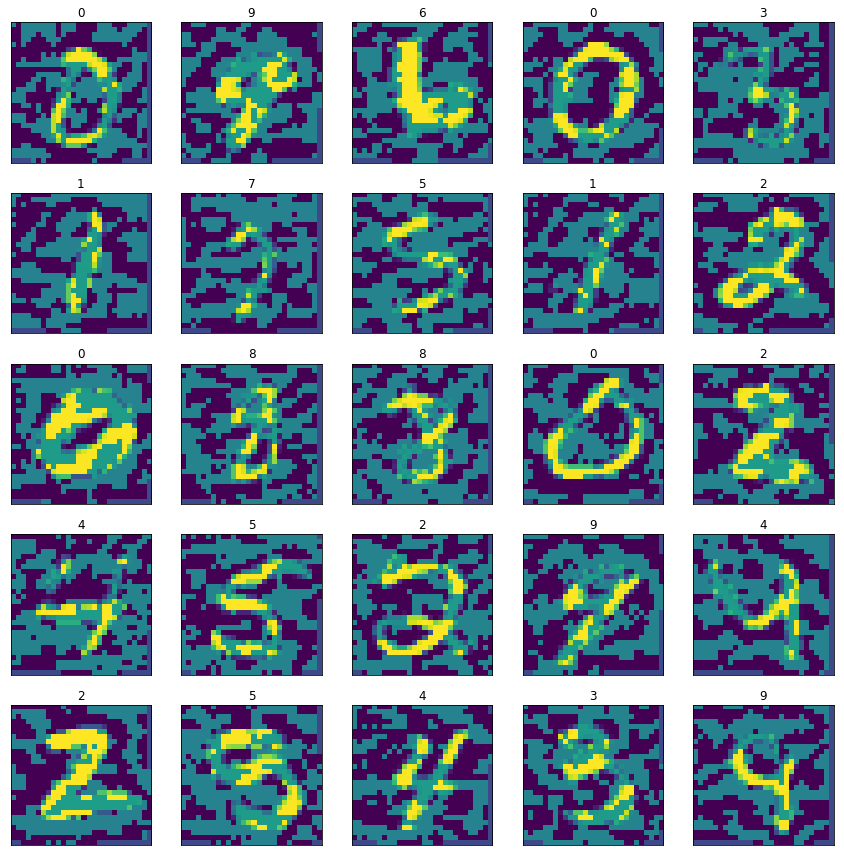

In [9]:
adv_x = adv_x.reshape((-1, 28, 28))
show_dataset_examples(adv_x, y_test, mnist_class_labels)